In [ ]:
# Importing relevant libraries

import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython import display
from numpy import expand_dims, zeros, ones
from numpy.random import randn, randint
from keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout 

## Dataset

In [ ]:
# data from: https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/
# code from: https://www.tensorflow.org/tutorials/generative/dcgan

#data = pd.read_csv('C:/Users/97254/Documents/Generative_Models/project/datasets/fer2013.csv')
data = pd.read_csv('./fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [ ]:
num_classes = 7
img_width = 48
img_height = 48

In [ ]:
data.shape

(35887, 3)

In [ ]:
X = data['pixels']
y = data['emotion']

In [ ]:
X_train = []
for i in X:
    X_train.append([int(j) for j in i.split()])

X_train = np.array(X_train)/255.0

In [ ]:
X_train = X_train.reshape(X_train.shape[0], img_width, img_height, 1)
X_train = X_train.astype('float32')

In [ ]:
X_train.shape

(35887, 48, 48, 1)

In [ ]:
# BUFFER_SIZE = 60000
# BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
#train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Discriminator Model

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(48,48,1)):
    model = Sequential()
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

## Generator Model

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 12x12 image
    n_nodes = 128 * 12 * 12
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((12, 12, 128)))
    # upsample to 24x24
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 48x48
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # generate
    model.add(Conv2D(1, (12, 12), activation='tanh', padding='same'))
    return model

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

In [ ]:
# noise_dim = 100
# num_examples_to_generate = 16
# seed = tf.random.normal([num_examples_to_generate, noise_dim])

latent_points = generate_latent_points(100, 16)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        start = time.time()
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
        #display.clear_output(wait=True)
        #latent_points = generate_latent_points(latent_dim, 10)
        #show_plot(g_model.predict(latent_points), 4)
        # summarize loss on this epoch
        print('Time for epoch %d: %.3f sec d1=%.3f d2=%.3f g=%.3f' % (i + 1, time.time() - start, d_loss1, d_loss2, g_loss))
      # Generate after the final epoch

    # save the generator model
    g_model.save('generator.h5')

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = X_train
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

Time for epoch 1: 41.647 sec d1=0.567 d2=0.791 g=0.617
Time for epoch 2: 41.704 sec d1=0.705 d2=0.686 g=0.708
Time for epoch 3: 41.751 sec d1=0.689 d2=0.705 g=0.690
Time for epoch 4: 41.882 sec d1=0.691 d2=0.701 g=0.690
Time for epoch 5: 41.920 sec d1=0.697 d2=0.692 g=0.697
Time for epoch 6: 41.988 sec d1=0.699 d2=0.688 g=0.700
Time for epoch 7: 42.106 sec d1=0.705 d2=0.680 g=0.710
Time for epoch 8: 42.001 sec d1=0.688 d2=0.708 g=0.686
Time for epoch 9: 42.221 sec d1=0.692 d2=0.692 g=0.700
Time for epoch 10: 42.013 sec d1=0.694 d2=0.692 g=0.699
Time for epoch 11: 42.044 sec d1=0.694 d2=0.691 g=0.700
Time for epoch 12: 41.986 sec d1=0.692 d2=0.695 g=0.695
Time for epoch 13: 42.031 sec d1=0.694 d2=0.691 g=0.697
Time for epoch 14: 41.944 sec d1=0.688 d2=0.703 g=0.692
Time for epoch 15: 41.831 sec d1=0.695 d2=0.697 g=0.695
Time for epoch 16: 41.965 sec d1=0.696 d2=0.691 g=0.699
Time for epoch 17: 41.921 sec d1=0.696 d2=0.690 g=0.698
Time for epoch 18: 42.157 sec d1=0.692 d2=0.697 g=0.695
T

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

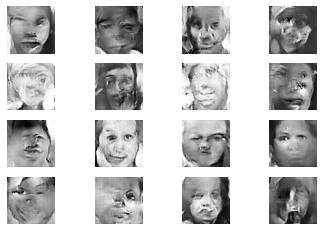

In [ ]:
# create and save a plot of generated images (reversed grayscale)
def show_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

# load model
model = load_model('generator.h5')
# generate images
latent_points = generate_latent_points(100, 16)
# generate images
X = 255-model.predict(latent_points)                #switching black and white
# plot the result
show_plot(X, 4)

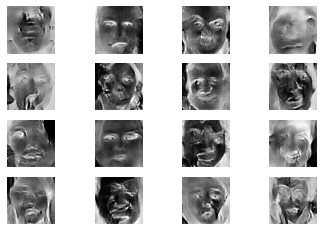

In [ ]:
# load model
model = load_model('generator.h5')
# generate images
latent_points = generate_latent_points(100, 16)
# generate images
X = model.predict(latent_points)
# plot the result
show_plot(X, 4)

## **conditional GAN**



In [1]:
# example of training an conditional gan on the fashion mnist dataset
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from numpy import expand_dims, zeros, ones, asarray
from numpy.random import randn, randint
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D  
from keras.layers import Conv2DTranspose, LeakyReLU, Dropout
from keras.layers import Embedding, Concatenate

## Discriminator Model

In [2]:
# define the standalone discriminator model
def define_discriminator(in_shape=(48,48,1), n_classes=7):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

## Generator Model

In [3]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=7):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 12 * 12
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((12, 12, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 12x12 image
	n_nodes = 128 * 12 * 12
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((12, 12, 128))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 24x24
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 48x48
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (12,12), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

## Gan Model

In [4]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

## Load and generate samples

In [10]:
# load fashion mnist images
def load_real_samples():
  data = pd.read_csv('./fer2013.csv')

  img_width = 48
  img_height = 48

  X = data['pixels']
  y = data['emotion']

  X_train = []
  for i in X:
      X_train.append([int(j) for j in i.split()])

  X_train = np.array(X_train)/255.0
  X_train = X_train.reshape(X_train.shape[0], img_width, img_height, 1)
  X_train = X_train.astype('float32')
  return [X_train, y]

In [6]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

In [7]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=7):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

In [8]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

## Train

In [9]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    start = time.time()
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      # generate 'fake' examples
      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      # prepare points in latent space as input for the generator
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
        # summarize loss on this batch
        #print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    print('Time for epoch %d: %.3f sec d1=%.3f d2=%.3f g=%.3f' % (i + 1, time.time() - start, d_loss1, d_loss2, g_loss))
  # save the generator model
  g_model.save('cgan_generator.h5')

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
#dataset = load_real_samples()
dataset = [X_train, y]
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Time for epoch 1: 39.982 sec d1=0.733 d2=0.599 g=1.121
Time for epoch 2: 31.732 sec d1=0.675 d2=0.678 g=0.864
Time for epoch 3: 32.044 sec d1=0.632 d2=0.723 g=0.844
Time for epoch 4: 31.827 sec d1=0.572 d2=0.717 g=1.020
Time for epoch 5: 32.384 sec d1=0.624 d2=0.630 g=0.934
Time for epoch 6: 32.016 sec d1=0.652 d2=0.666 g=0.933
Time for epoch 7: 32.727 sec d1=0.662 d2=0.694 g=0.877
Time for epoch 8: 32.514 sec d1=0.662 d2=0.713 g=0.933
Time for epoch 9: 32.768 sec d1=0.651 d2=0.629 g=0.930
Time for epoch 10: 32.616 sec d1=0.668 d2=0.684 g=0.985
Time for epoch 11: 32.789 sec d1=0.590 d2=0.642 g=0.878
Time for epoch 12: 32.666 sec d1=0.610 d2=0.672 g=0.834
Time for epoch 13: 32.814 sec d1=0.675 d2=0.668 g=0.824
Time for epoch 14: 32.694 sec d1=0.642 d2=0.698 g=0.854
Time for epoch 15: 32.813 sec d1=0.670 d2=0.691 g=0.915
Time for epoch 16: 32.665 sec d1=0.665 d2=0.675 g=0.885
Time for epoch 17: 32.403 sec d1=0.635 d2=0.591 g=0.955
Time for epoch 18: 32.445 sec d1=0.686 d2=0.633 g=0.932
T

In [11]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Time for epoch 1: 67.573 sec d1=0.788 d2=0.634 g=0.951
Time for epoch 2: 58.620 sec d1=0.662 d2=0.584 g=0.937
Time for epoch 3: 58.848 sec d1=0.652 d2=0.605 g=0.829
Time for epoch 4: 58.954 sec d1=0.633 d2=0.662 g=0.870
Time for epoch 5: 59.051 sec d1=0.651 d2=0.652 g=0.851
Time for epoch 6: 59.152 sec d1=0.610 d2=0.673 g=0.813
Time for epoch 7: 58.902 sec d1=0.680 d2=0.673 g=0.809
Time for epoch 8: 59.131 sec d1=0.658 d2=0.710 g=0.962
Time for epoch 9: 58.856 sec d1=0.638 d2=0.625 g=0.826
Time for epoch 10: 58.977 sec d1=0.664 d2=0.712 g=0.847
Time for epoch 11: 59.111 sec d1=0.629 d2=0.629 g=0.914
Time for epoch 12: 59.134 sec d1=0.590 d2=0.635 g=0.932
Time for epoch 13: 59.327 sec d1=0.661 d2=0.629 g=0.931
Time for epoch 14: 59.268 sec d1=0.646 d2=0.704 g=0.814
Time for epoch 15: 59.051 sec d1=0.652 d2=0.616 g=0.934
Time for epoch 16: 59.203 sec d1=0.669 d2=0.634 g=0.816
Time for epoch 17: 58.954 sec d1=0.678 d2=0.603 g=0.947
Time for epoch 18: 59.140 sec d1=0.623 d2=0.635 g=0.826
T

## Generate Results

In [12]:
def plot_images(model, predictions, n_classes):
  fig = plt.figure(figsize=(n_classes,n_classes))
  for i in range(predictions.shape[0]):
      plt.subplot(n_classes, n_classes, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('generated_images.png')
  plt.show()

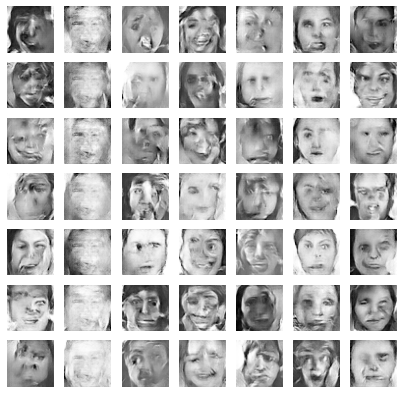

In [13]:
n_classes = 7
# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, n_classes*n_classes)
# specify labels
labels = asarray([x for _ in range(n_classes) for x in range(n_classes)])
# generate images
predictions = model.predict([latent_points, labels])
# plot the result
plot_images(model, predictions, n_classes)